In [1]:
import sys
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")
from openCSV import openCSV
import matplotlib.pyplot as plt
import numpy as np
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import itertools
from scipy import linalg
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#test_csv = openCSV("../converteddata/data2_1.csv")
test_csv = openCSV("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/labeledcsv/CoBo_2018-06-20T10-51-39.459_0000.csv")
test_csv.readCSV()

entry_nr = 25

singular_entry = test_csv.m_data[test_csv.m_data["entry_nr"]==entry_nr]


if singular_entry.empty:
    print("The value ", entry_nr, "s was not found in the 'entry_nr' column.")
else:
    print("The value ", entry_nr, " was found in the 'entry_nr' column.")

The value  25  was found in the 'entry_nr' column.


In [3]:
# get all unique values in the "entry_nr" column
unique_entries = test_csv.m_data["entry_nr"].unique()

# print the unique values
print("The unique values in the 'entry_nr' column are:")
for entry in unique_entries:
    print(entry)

The unique values in the 'entry_nr' column are:
1
5
6
7
10
13
16
23
25
27
29
30
35
38
39
40
42
46
49
53
54
56
61
65
66
71
75
76
79
87
92
93
96
98
102
107
114
126
127
128
132
133
134
137
140
142
144
148
149
154
155
156
160
166
167
168
175
181
192
195
196
201
204
207
208
210
216
224
225
226
228
230
231
235
236
238
249
251
254
255
256
259
261
268
269
271
274
276
277
278
281
283
285
289
293
298
301
304
307
308
311
312
314
316
319
325
332
337
344
345
346
349
350
352
355
357
358
359
365
368
374
376
384
394
403
406
408
409
410
418
421
425
428
430
431
434
435
438
440
446
450
451
452
458
462
464
471
474
475
477
478
480
486
487
491
497
500
502
505
507
509
510
517
520
522
523
526
527
528
531
532
533
535
537
538
544
547
549
557
561
562
564
567
568
569
572
573
580
583
584
587
588
592
594
597
602
610
612
614
623
624
629
634
640
644
652
655
656
660
664
672
675
677
680
683
684
685
687
692
694
695
698
700
701
706
712
713
719
722
723
724
726
728
730
731
733
734
736
737
739
743
744
745
750
751
756
758
76

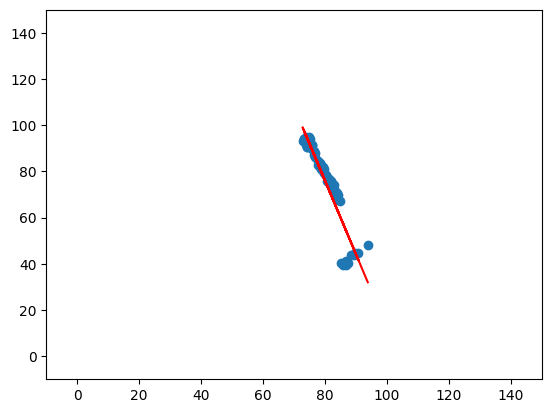

Mean squared error: 37.676033242977226


In [4]:
#Try linear regression
x = singular_entry['x'].to_numpy()
y = singular_entry['y'].to_numpy()

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Predict y values based on the linear regression model
y_pred = model.predict(x)

# Plot the data and the linear regression line
plt.scatter(x, y)
plt.xlim(-10, 150)
plt.ylim(-10, 150)
plt.plot(x, y_pred, color='red')
plt.show()

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y, y_pred)
print('Mean squared error:', mse)

In [5]:
#Essentials
scaler = MinMaxScaler()
fte_colors = {
    -1: "#000000",
    0: "#008fd5",
    1: "#fc4f30",
    2: "#ac434d"
}

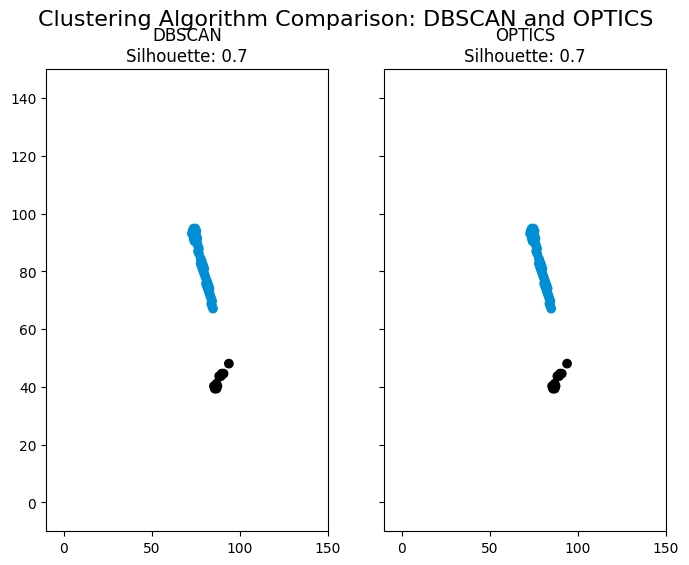

In [6]:
#try using dbscan and optics

features = singular_entry[['x', 'y']].to_numpy()
scaled_features = scaler.fit_transform(features)
#scaled_features=features


dbscan = DBSCAN(eps=0.3, min_samples = int(features[:, 0].size/3))
optics = OPTICS(min_cluster_size = int(2*features[:, 0].size/3))

dbscan.fit(scaled_features)
optics.fit(scaled_features)



if len(np.unique(dbscan.labels_)) > 1:
    dbscan_silhouette = silhouette_score(
        scaled_features, dbscan.labels_
    ).round(2)
else:
    dbscan_silhouette = 0

if len(np.unique(optics.labels_)) > 1:
    optics_silhouette = silhouette_score(
        scaled_features, optics.labels_
    ).round(2)
else:
    optics_silhouette = 0





fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: DBSCAN and OPTICS", fontsize=16)


# The dbscan plot
db_colors = [fte_colors[label] for label in dbscan.labels_]
ax1.scatter(features[:, 0], features[:, 1], c=db_colors)
ax1.set_title(
    f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
)
ax1.set_xlim([-10, 150])
ax1.set_ylim([-10, 150])

op_colors = [fte_colors[label] for label in optics.labels_]
ax2.scatter(features[:, 0], features[:, 1], c=op_colors)
ax2.set_title(
    f"OPTICS\nSilhouette: {optics_silhouette}", fontdict={"fontsize": 12}
)
ax2.set_xlim([-10, 150])
ax2.set_ylim([-10, 150])


plt.show()

In [ ]:
#Now try using Gaussian mixture and Baesyan Gaussian mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-10.0, 150.0)
    plt.ylim(-10.0, 150.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


gmm = GaussianMixture(n_components=3, covariance_type="full").fit(features)
plot_results(features, gmm.predict(features), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = BayesianGaussianMixture(n_components=3, covariance_type="full").fit(features)
plot_results(
    features,
    dpgmm.predict(features),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.show()

In [ ]:
%matplotlib widget


#try for 3d

features3d = singular_entry[['x', 'y', 'z']].to_numpy()
scaled_features3d = scaler.fit_transform(features)
#scaled_features=features


dbscan3d = DBSCAN(eps=0.3, min_samples = 10)
optics3d = OPTICS(min_cluster_size = int(2 * features[:, 0].size/3))

dbscan3d.fit(scaled_features)
optics3d.fit(scaled_features)



if len(np.unique(dbscan3d.labels_)) > 1:
    dbscan3d_silhouette = silhouette_score(
        scaled_features3d, dbscan3d.labels_
    ).round(2)
else:
    dbscan3d_silhouette = 0

if len(np.unique(optics3d.labels_)) > 1:
    optics3d_silhouette = silhouette_score(
        scaled_features3d, optics3d.labels_
    ).round(2)
else:
    optics3d_silhouette = 0



print(dbscan3d_silhouette)
print(optics3d_silhouette)



fig3ddb = plt.figure()


ax3d = fig3ddb.add_subplot(1, 2, 1, projection='3d')
db_colors3d = [fte_colors[label] for label in dbscan3d.labels_]
ax3d.scatter(features3d[:, 0], features3d[:, 1], features3d[:, 2], c=db_colors3d, marker='o')
ax3d.set_title(
    f"DBSCAN\nSilhouette: {dbscan3d_silhouette}", fontdict={"fontsize": 12}
)
ax3d.set_xlim([-10, 150])
ax3d.set_ylim([-10, 150])



ax3d = fig3ddb.add_subplot(1, 2, 2, projection='3d')
op_colors3d = [fte_colors[label] for label in optics3d.labels_]
ax3d.scatter(features3d[:, 0], features3d[:, 1], features3d[:, 2], c=op_colors3d, marker='o')
ax3d.set_title(
    f"OPTICS\nSilhouette: {optics3d_silhouette}", fontdict={"fontsize": 12}
)

ax3d.set_xlim([-10, 150])
ax3d.set_ylim([-10, 150])











plt.show()

0.806898783458353


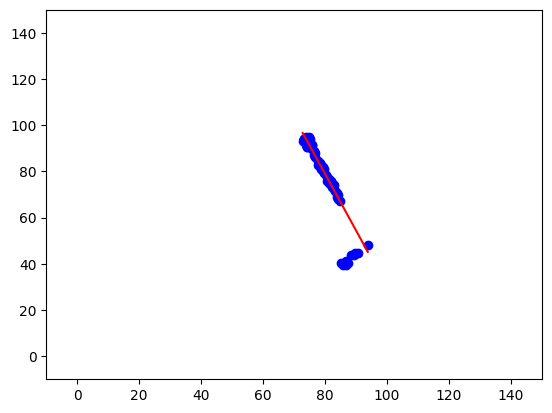

In [7]:
features = singular_entry[['x', 'y']].to_numpy()
x = features[:, 0].reshape(-1, 1)
y = features[:, 1]


reg = RANSACRegressor(random_state=0).fit(x, y)
print(reg.score(x, y))

slope = reg.estimator_.coef_[0]
intercept = reg.estimator_.intercept_


x = np.array([np.min(x), np.max(x)])
y = slope * x + intercept


# Plot the data points
plt.scatter(features[:, 0], features[:, 1], color='blue', label='Data points')

# Plot the fitted line
plt.plot(x, y, color='red', label='Fitted line')

plt.xlim(-10.0, 150.0)
plt.ylim(-10.0, 150.0)

# Show the plot
plt.show()

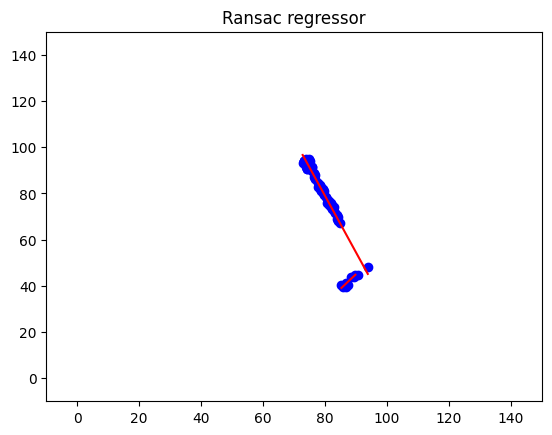

In [8]:
features = singular_entry[['x', 'y']].to_numpy()

#Number of lines
n = 2

inliers = np.empty(n, dtype=object)

x = np.empty(n, dtype=object)
y = np.empty(n, dtype=object)

#Set the inlier array to 0 because we always care about the outliers, meaning the we set everything to outliers at first
inliers[0] = np.zeros(len(features), dtype=bool)



all_inliers = np.zeros(features.shape[0], dtype=bool)
for i in range(n):
    # Break if there are no more outliers.
    if np.all(all_inliers):
        print("There are no outliers at i = ", i)
        break

    # Exclude the inliers from all previous iterations.
    current_outliers = np.logical_not(all_inliers)

    # Fit a line to the current outliers
    reg = RANSACRegressor(random_state=56).fit(features[current_outliers][:, 0].reshape(-1, 1), features[current_outliers][:, 1])
    
    # Get the slope and intercept of the fitted line.
    slope = reg.estimator_.coef_[0]
    intercept = reg.estimator_.intercept_
    
    # Get the x and y values for the line.
    x[i] = np.array([np.min(features[current_outliers][:, 0]), np.max(features[current_outliers][:, 0])])
    y[i] = slope * x[i] + intercept
    
    #Calculate the outliers.
    if i != n-1:
        #Initiate everything as outliers.
        next_inliers = np.zeros(features.shape[0], dtype=bool)

        #Only select the points which are outliers in the current iteration 'i' which have been used by RANSACRegressor.
        #The reg.inlier_mask_ only returs the mask for the points used by RANSACRegressor so we must make sure to only select them.
        next_inliers[current_outliers] = reg.inlier_mask_

        # Update all_inliers with the inliers from this iteration.
        all_inliers = np.logical_or(all_inliers, next_inliers)



# Plot the data points
plt.scatter(features[:, 0], features[:, 1], color='blue', label='Data points')

# Plot the fitted lines
for i in range(n):
    if x[i] is not None and y[i] is not None:
        plt.plot(x[i], y[i], color='red', label='Fitted line {}'.format(i + 1))

plt.xlim(-10.0, 150.0)
plt.ylim(-10.0, 150.0)
plt.title("Ransac regressor")

# Show the plot
plt.show()
